# Hotel Reservation

---
I. Problem definition<br>
II. About the Data

1. Import Packages
2. Userdefined Functions
3. Load the Data and Create Test Set
4. Explore the data to gain Insights<br>
    4.1 General Overview over the Data<br>
    4.2 Analyse the Independent Variable<br>
    4.3 EDA<br>
5. Feature Engineering
6. Prepare the Data<br>
    6.1 Handling Skewed Data<br>
    6.2 OneHotEncoding and Scaling<br>
7. Feature Selection (RFECV)
8. Explore many Different Models
9. Fine-tune the best Models
10. Ensemble/Volting Classifier
11. Test and Analyse the Final Model


---

## I. Problem definition

The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. A machine learning model could help to predict cancelations and thus help to keep the revenue high.

## II. About the Data

The file contains the different attributes of customers' reservation details. The detailed data dictionary is given below.

- Booking_ID: unique identifier of each booking
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.

## 1. Import Packages

In [466]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import math
import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

## 2. Userdefined Functions

In [467]:
def plot_categorical_features(df, categorical_features, independent_variable,m):
    # This function creates important plots to visualize categorical features
    n= math.ceil(len(categorical_features)/m)
    for i, col in enumerate(categorical_features):
        plt.subplot(n, m, i+1)
        sns.countplot(x =categorical_features[i], data= df, hue= independent_variable)
        plt.title(categorical_features[i])
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [468]:
def plot_ordinal_features(df, ordinal_features, independent_variable):
    # This function creates important plots to visualize ordinal features
    n = len(ordinal_features)
    f, axs = plt.subplots(n, 3,figsize=(20,20))
    for i, col in enumerate(ordinal_features):
        
        #bins = np.histogram_bin_edges(df[ordinal_features[i]], bins='auto')
        bins = np.histogram_bin_edges(df[ordinal_features[i]], bins='auto')
        sns.histplot(df[ordinal_features[i]],bins=bins, ax=axs[i,0])
        for ax in axs[i]:
            for p in ax.patches:
                x, w, h = p.get_x(), p.get_width(), p.get_height()
                if h > 0:
                    ax.text(x + w / 2, h, f'{h}\n', ha='center', va='center', size=8)
            ax.margins(y=0.07)
        axs[i, 0].set_title(ordinal_features[i])
        sns.countplot(x =ordinal_features[i], data= df, hue= independent_variable, ax=axs[i,1])
        #sns.histplot(data=df, x=ordinal_features[i], hue = independent_variable, ax=axs[i,1])
        axs[i, 1].set_title(ordinal_features[i])
        df1 = df.groupby([ordinal_features[i],independent_variable]).size().reset_index()
        df1.columns = [ordinal_features[i], independent_variable, 'count']
        df1 = df1.pivot(index=ordinal_features[i],columns=independent_variable,values='count')
        df1.iloc[:, 0] = df1.iloc[:, 0].fillna(0)
        df1['ratio'] = df1.iloc[:, 1] / (df1.iloc[:, 1] + df1.iloc[:, 0])
        sns.barplot(x = ordinal_features[i], y = 'ratio', data = df1.reset_index(), ax=axs[i,2])
        axs[i,2].set_title(f"ratio of {ordinal_features[i]}, canceled to not_canceled")
    plt.subplots_adjust(hspace=1)
    plt.show()

In [469]:
def reduce_skewness(df, skewed_feature):
    from scipy.stats import boxcox
    # This function chooses and applies the best method for skewness reduction
    # create a new DataFrame with the skewed feature and add several transformations
    df_skewness = pd.DataFrame({skewed_feature:df[skewed_feature]})
    df_skewness[skewed_feature+"_log"]=np.log(df[skewed_feature])
    df_skewness[skewed_feature+"_sqrt"] = df[skewed_feature]**(.5)
    df_skewness[skewed_feature+"_reciprocal"] = 1/df[skewed_feature]
    if ~np.any(df_skewness[skewed_feature] <= 0):
        df_skewness[skewed_feature+"_boxcox"] = df[skewed_feature], lmbda = boxcox(df[skewed_feature], lmbda=None)

    # Prints the new skewness, a histplot and returns the column with the smallest skewness
    skew_new = np.argmin(abs(df_skewness.skew()))
    print(f"{round(df_skewness[skewed_feature].skew(),2)}-->{round((df_skewness.iloc[:,skew_new]).skew(),2)}\nUsed method: {df_skewness.columns[skew_new]}")
    plt.figure(figsize=(8, 3))
    sns.histplot(df_skewness.iloc[:,skew_new])
    return df_skewness.iloc[:,skew_new]

In [470]:
def evaluation(model,x_test,y_test):
    
    print("Test AUC:",roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
    print('Train AUC:',roc_auc_score(y_train, model.predict_proba(x_train)[:,1]))

## 3. Load the Data and Create Test Set

In [471]:
df = pd.read_csv("Daten\Hotel_Reservations.csv")

In [472]:
df.head().style.set_properties(**{'background-color': 'lightblue',
                           'color': 'black',
                           'border-color': 'darkblack'})

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.000000,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.680000,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.000000,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.000000,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.500000,0,Canceled


Create the test set with Stratified Shuffle Split to keep the distribution of the classes

In [473]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["booking_status"]):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

## 4. Explore the data to gain Insights

### 4.1 General Overview over the Data

In [474]:
display(train_data.shape)
display(train_data.size)

(29020, 19)

551380

In [475]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29020 entries, 9078 to 29823
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            29020 non-null  object 
 1   no_of_adults                          29020 non-null  int64  
 2   no_of_children                        29020 non-null  int64  
 3   no_of_weekend_nights                  29020 non-null  int64  
 4   no_of_week_nights                     29020 non-null  int64  
 5   type_of_meal_plan                     29020 non-null  object 
 6   required_car_parking_space            29020 non-null  int64  
 7   room_type_reserved                    29020 non-null  object 
 8   lead_time                             29020 non-null  int64  
 9   arrival_year                          29020 non-null  int64  
 10  arrival_month                         29020 non-null  int64  
 11  arrival_date

There are 5 features with the dtype object. They have to be transformed<br>
booking_ID is probably a useless feature<br>
booking_status is the independent variable

In [476]:
train_data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000
mean,1.846623,0.104859,0.810855,2.203308,0.031496,85.127016,2017.820193,7.431978,15.580875,0.025775,0.022674,0.157960,103.533282,0.620331
std,0.518991,0.402785,0.871787,1.415096,0.174656,85.921809,0.384033,3.070065,8.728470,0.158467,0.368525,1.796362,35.147072,0.788429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.492500,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.900000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.600000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [477]:
train_data.nunique()

Booking_ID                              29020
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 349
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations                9
no_of_previous_bookings_not_canceled       56
avg_price_per_room                       3489
no_of_special_requests                      6
booking_status                              2
dtype: int64

avg_price_per_room seems to be the only true numerical value, others are categorical or ordinal<br>
lead_time is an ordinal feature with a big range,so it can be treated like a numerical feature

In [478]:
train_data.isnull().mean()*100

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

There are no null values

In [479]:
train_data["type_of_meal_plan"].value_counts()

Meal Plan 1     22241
Not Selected     4117
Meal Plan 2      2657
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

In [480]:
train_data["room_type_reserved"].value_counts()

Room_Type 1    22498
Room_Type 4     4862
Room_Type 6      764
Room_Type 2      546
Room_Type 5      222
Room_Type 7      123
Room_Type 3        5
Name: room_type_reserved, dtype: int64

There are 5 cases For type_of_meal_plan and room_type_reserved each that have there own category
It would be interesting to find out if they are the same 5 cases

In [481]:
train_data["market_segment_type"].value_counts()

Online           18610
Offline           8381
Corporate         1612
Complementary      314
Aviation           103
Name: market_segment_type, dtype: int64

Now i will divide the features into different feature lists to handle them faster later on

In [482]:
categorical_features = ["type_of_meal_plan", "market_segment_type", "repeated_guest", "required_car_parking_space", "room_type_reserved"]
ordinal_features =["no_of_week_nights", "no_of_previous_bookings_not_canceled", "no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_previous_cancellations", "no_of_special_requests"]

### 4.2 Analyse the Independent Variable

In [483]:
train_data["booking_status"].value_counts()

Not_Canceled    19512
Canceled         9508
Name: booking_status, dtype: int64

([<matplotlib.patches.Wedge at 0x17f0ac5c130>,
 [Text(-0.5669614309335993, 0.9426318135060612, 'Not_Canceled'),
  Text(0.5669614309335992, -0.9426318135060612, 'Canceled')],
 [Text(-0.30925168960014504, 0.5141628073669424, '67.2%'),
  Text(0.309251689600145, -0.5141628073669424, '32.8%')])

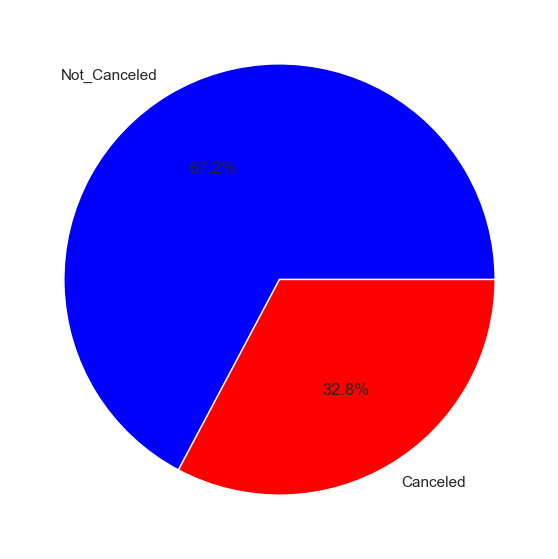

In [484]:
plt.figure(figsize=(7,7))
plt.pie(train_data["booking_status"].value_counts(), labels = ["Not_Canceled","Canceled"], colors= ['blue','red'],autopct='%3.1f%%')

The independent variable is slightly imbalanced but it is not likely that this will have a big impact on the model

### 4.3 EDA

First i create copy to perform transformations without loosingthe original data

In [485]:
df_EDA = pd.DataFrame(train_data)

Visualizing the categorical features:

<Figure size 800x800 with 0 Axes>

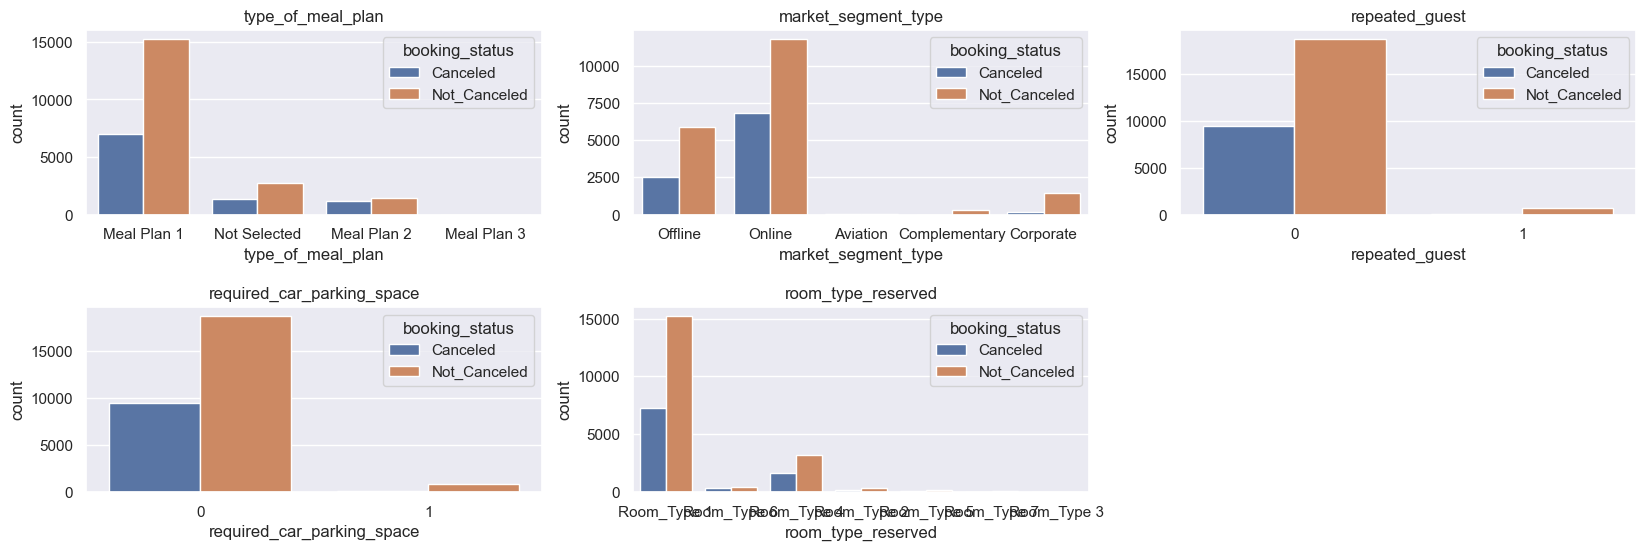

In [486]:
plt.figure()
plt.figure(figsize=(20,6))
plot_categorical_features(df_EDA, categorical_features, "booking_status",3)


Regular guests and corporate guests rarely cancel

Visualizing the ordinal features:

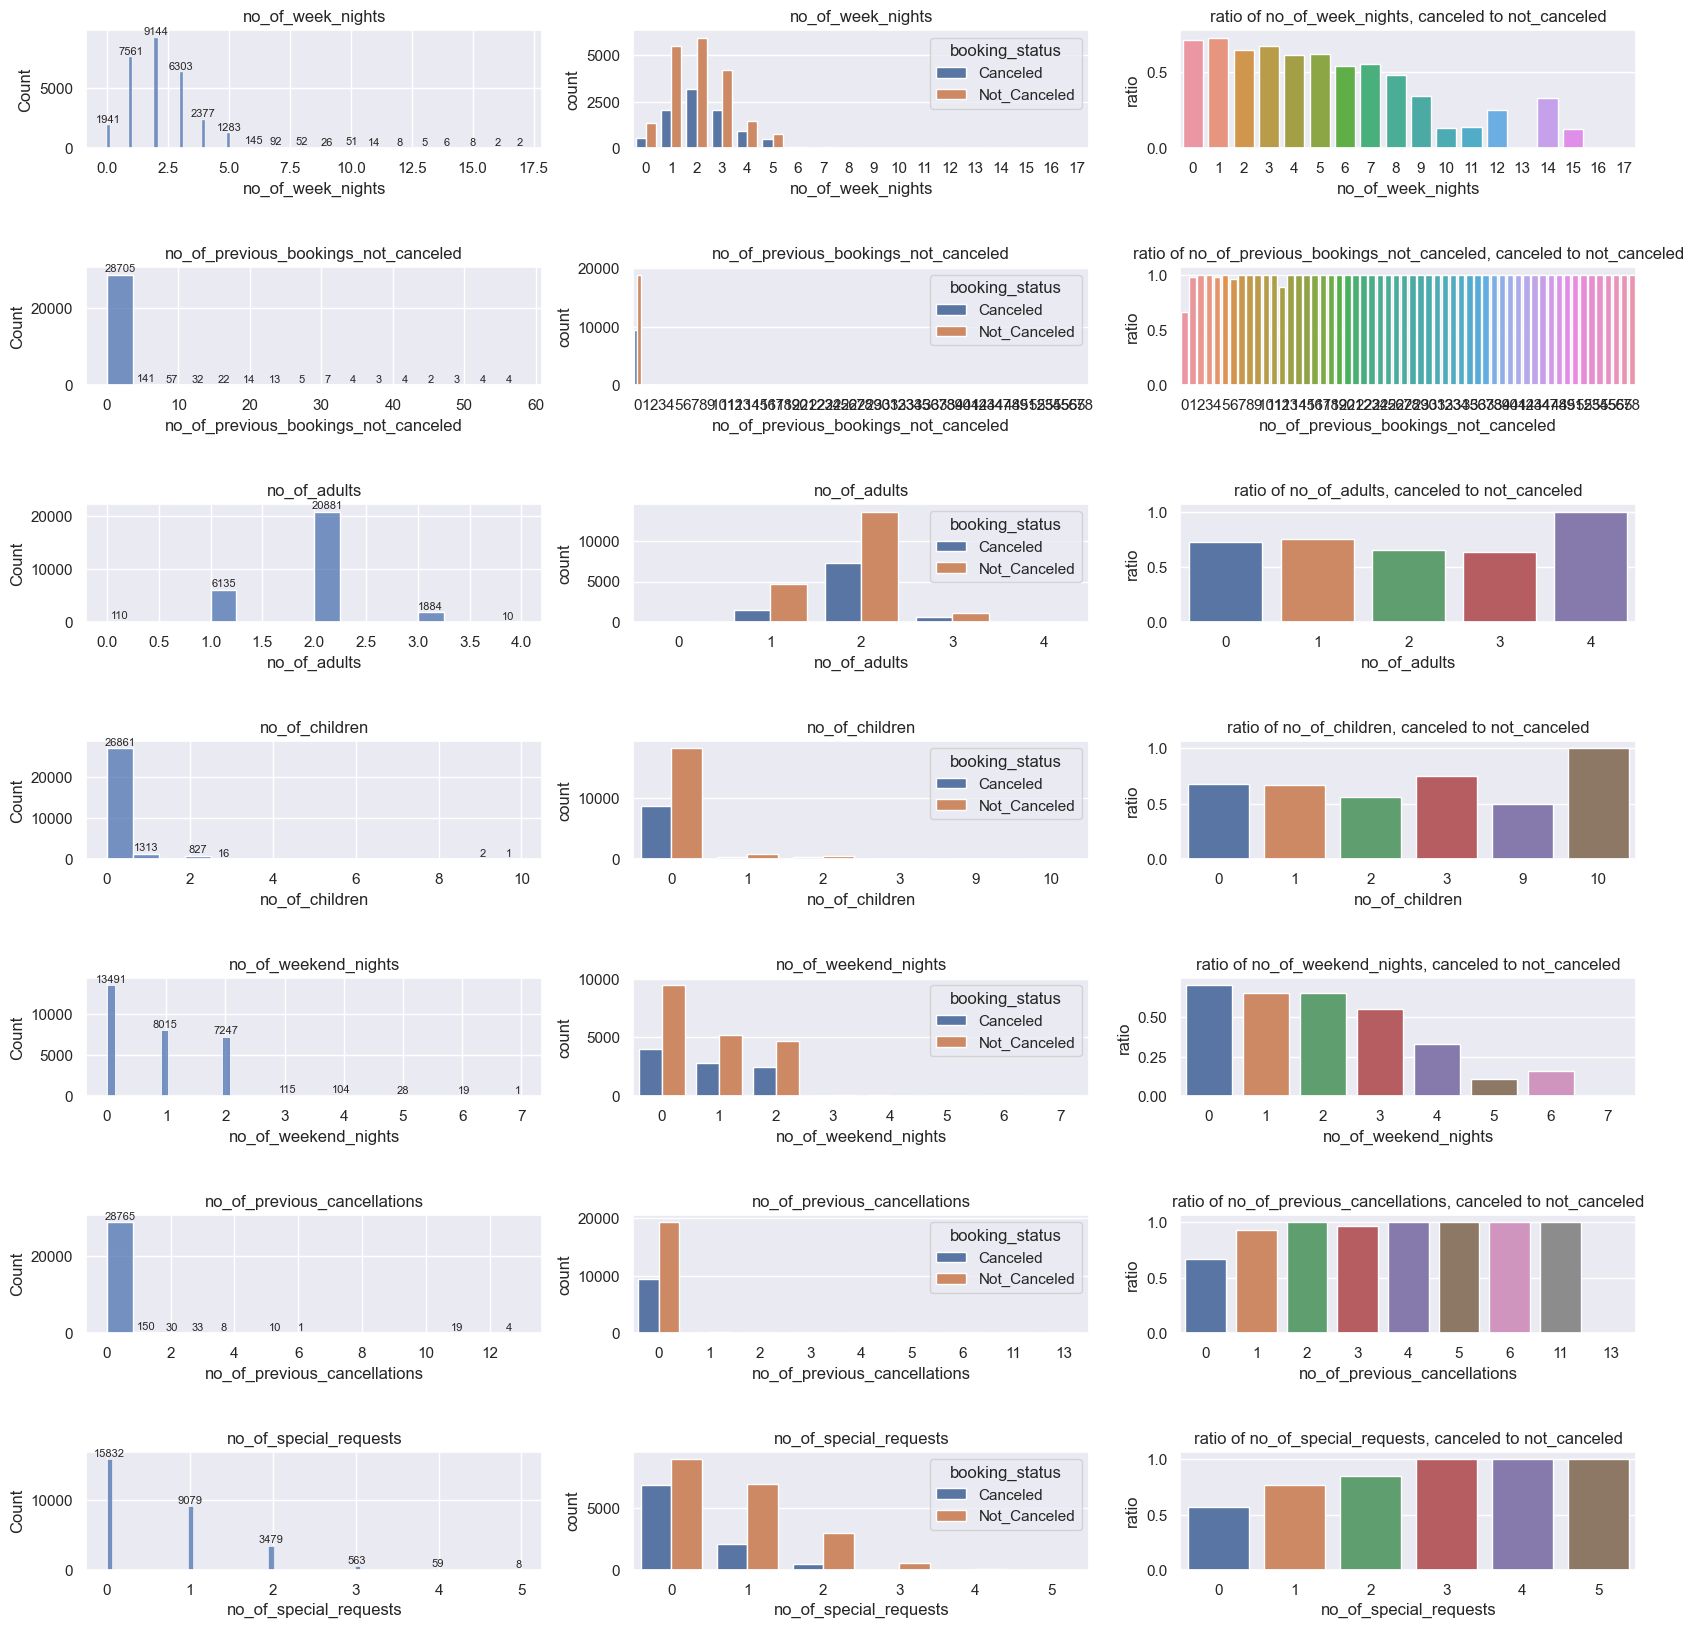

In [487]:
plot_ordinal_features(df_EDA, ordinal_features, "booking_status")

no_of_weeks_nights: the more week nights are booked the more likely is a cancelation<br>
no_of_previous_bookings_not_canceled: people who did not canceled in previous bookings are not likely to cancel<br>
no_of_weekend_nights: The same behavior as no_of_week_nights<br>
no_of_previous_cancellations: A cancelation is more likely when there hasnt been any previous cancelations<br>
no_of_special_requests:  A cancelation is more likely when there are less special requests<br>

Visualizing the numerical features:

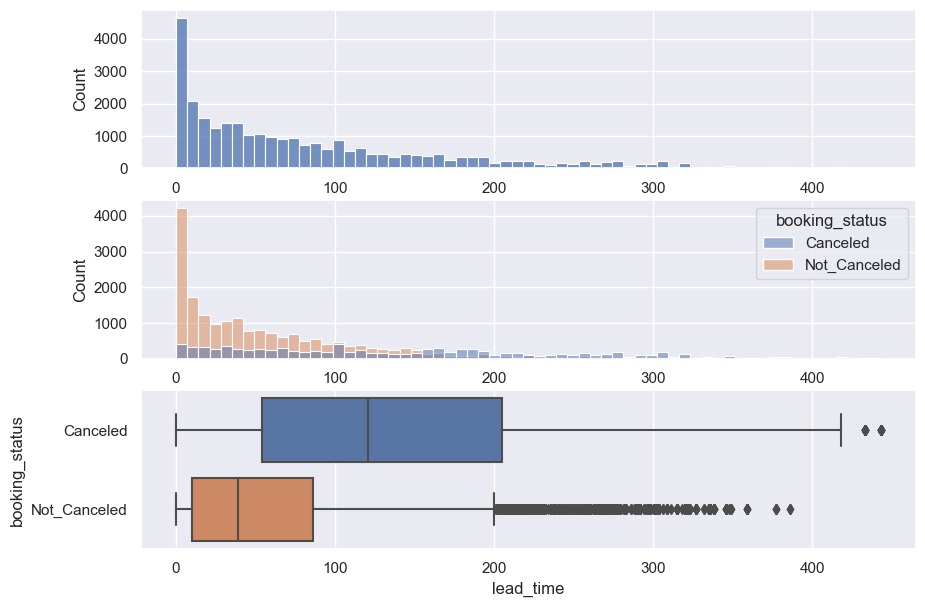

In [488]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="lead_time", ax=ax[0])
t = sns.histplot(data=df_EDA, x="lead_time", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="lead_time", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

lead_time is a skewed feature<br>
bookings with a large lead time tend to cancel more often

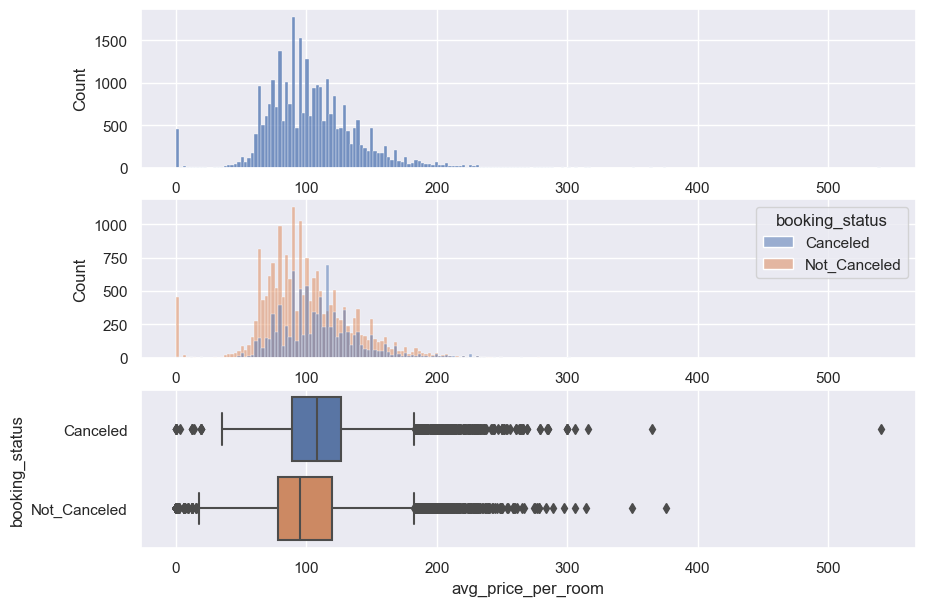

In [489]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="avg_price_per_room", ax=ax[0])
t = sns.histplot(data=df_EDA, x="avg_price_per_room", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="avg_price_per_room", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

avg_price_per_room is also skewed
There are no obvious tendencies for cancellations except that there are no cancellations if the room is free

<AxesSubplot: xlabel='lead_time', ylabel='avg_price_per_room'>

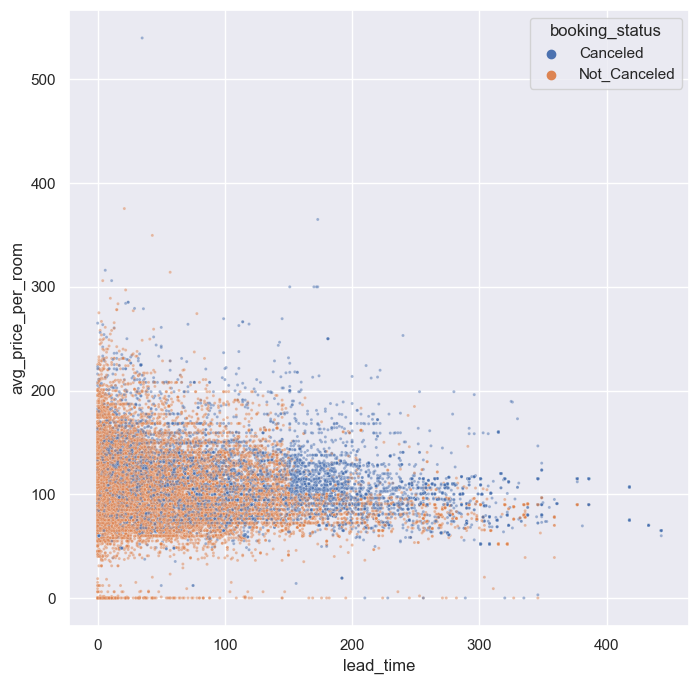

In [490]:
sns.scatterplot(data=df_EDA, x="lead_time", y="avg_price_per_room", hue="booking_status",s=5,alpha=0.5)

The scatterplot reveals that most reservations that have high avg_price_per_room and also high lead_time get canceled

To see how the cancelation profile is changing over time i transform the three columns for day, month and year into one date column

In [491]:
df_EDA['arrival_date']=df_EDA.apply(lambda row: 28 if (row['arrival_month'] == 2 and row['arrival_date'] > 28) else row['arrival_date'], axis=1)
df_EDA['complete_arrival_date']=df_EDA.apply(lambda x: datetime.date(x['arrival_year'], x['arrival_month'], x['arrival_date']), axis=1)

In [492]:
# Add a column with the count of cancellations per date
df_EDA["count"] = 1
canceled_df = df_EDA[df_EDA["booking_status"]=="Canceled"].groupby("complete_arrival_date")["count"].sum()
not_canceled_df = df_EDA[df_EDA["booking_status"]=="Not_Canceled"].groupby("complete_arrival_date")["count"].sum()

# Create a new dataframe with the ratio of cancelled bookings
result = pd.concat([canceled_df, not_canceled_df], axis=1)
result.columns = ['canceled', 'not_canceled']
result['canceled'].fillna(1)
result["ratio"] = result["not_canceled"] / (result["canceled"] + result["not_canceled"])
result["total"] = result["canceled"] + result["not_canceled"]
result =pd.DataFrame(result)

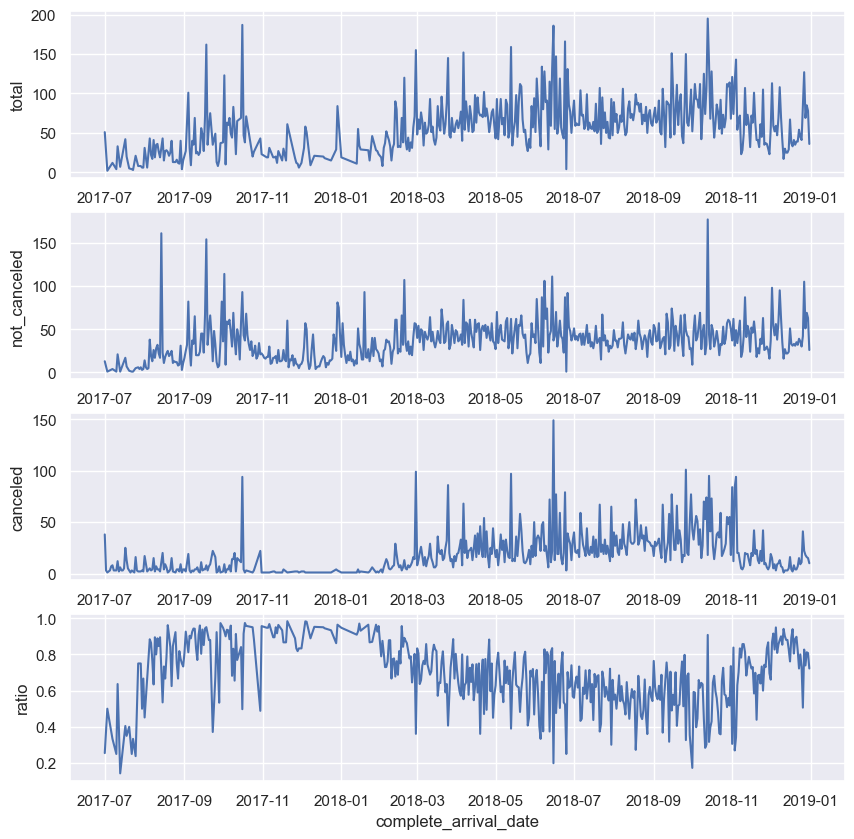

In [493]:
fig, ax = plt.subplots(4, figsize=(10, 10))

t = sns.lineplot(data=result, x="complete_arrival_date", y="total", ax=ax[0])
t = sns.lineplot(data=result, x="complete_arrival_date", y="not_canceled", ax=ax[1])
t = sns.lineplot(data=result, x="complete_arrival_date", y="canceled", ax=ax[2])
t = sns.lineplot(data=result, x="complete_arrival_date", y="ratio", ax=ax[3])

It is difficult to see any patterns in these plots
Maybe it is better to show the bookings for each month instead of each day

In [494]:
df_EDA['complete_arrival_date']=df_EDA.apply(lambda x: datetime.date(x['arrival_year'], x['arrival_month'],1), axis=1)

In [495]:
# Add a column with the count of cancellations per date
df_EDA["count"] = 1
canceled_df = df_EDA[df_EDA["booking_status"]=="Canceled"].groupby("complete_arrival_date")["count"].sum()
not_canceled_df = df_EDA[df_EDA["booking_status"]=="Not_Canceled"].groupby("complete_arrival_date")["count"].sum()

# Create a new dataframe with the ratio of cancelled bookings
result = pd.concat([canceled_df, not_canceled_df], axis=1)
result.columns = ['canceled', 'not_canceled']
result['canceled'].fillna(1)
result["ratio/not_canceled to canceled"] = result["not_canceled"] / (result["canceled"] + result["not_canceled"])
result["total"] = result["canceled"] + result["not_canceled"]
result =pd.DataFrame(result)

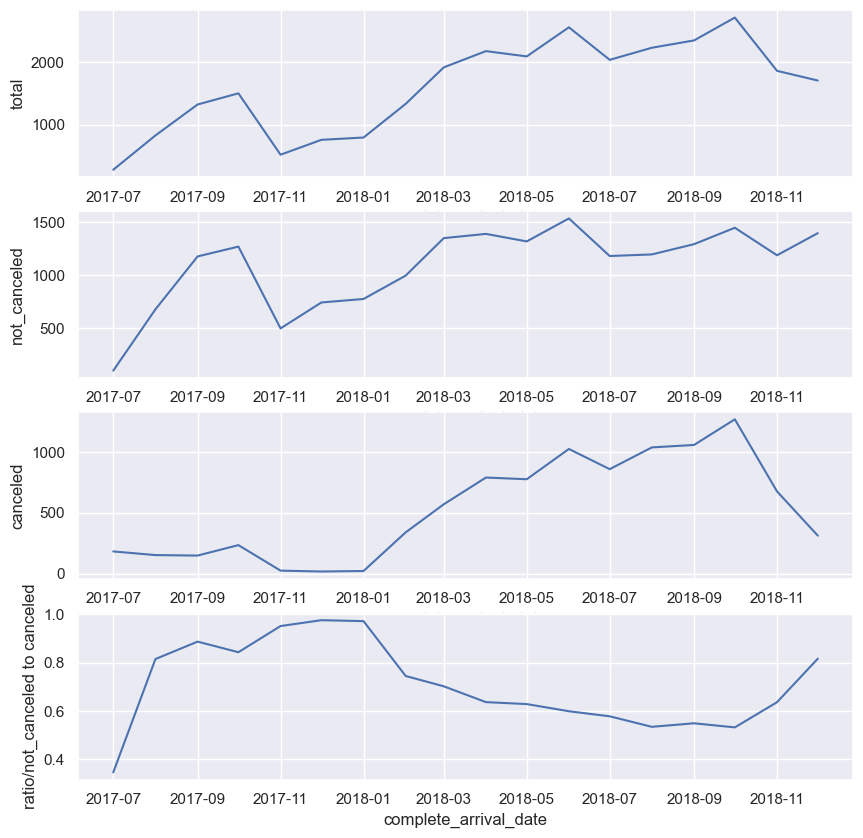

In [496]:
fig, ax = plt.subplots(4, figsize=(10, 10))

t = sns.lineplot(data=result, x="complete_arrival_date", y="total", ax=ax[0])
t = sns.lineplot(data=result, x="complete_arrival_date", y="not_canceled", ax=ax[1])
t = sns.lineplot(data=result, x="complete_arrival_date", y="canceled", ax=ax[2])
t = sns.lineplot(data=result, x="complete_arrival_date", y="ratio/not_canceled to canceled", ax=ax[3])

In these graphs the trends are more visible
The number of bookings doesnt depend as much on the season as you might think
In the year 2018 there are more bookings and the cancelation ratio is higher

<AxesSubplot: xlabel='room_type_reserved', ylabel='type_of_meal_plan'>

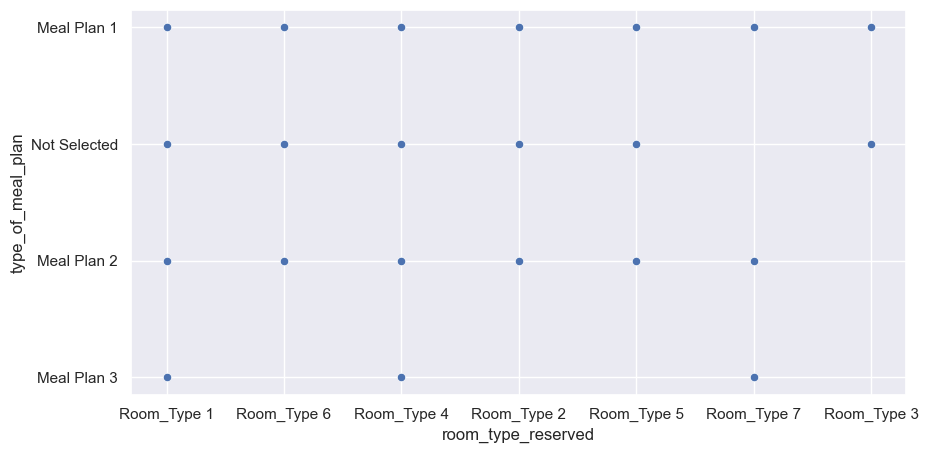

In [497]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x = "room_type_reserved", y="type_of_meal_plan",  data= df_EDA)

Meal Plan 3 and Room_Type 3 (the two classes with 5 cases each) have no correlation

## 5. Feature Engineering

I calculate additional features that could be helpful for the solution

In [498]:
df_EDA['overall_people'] = df_EDA['no_of_children'] + df_EDA['no_of_adults']
df_EDA['overall_nights'] = df_EDA['no_of_weekend_nights'] + df_EDA['no_of_week_nights']
df_EDA['overall_price'] = df_EDA['avg_price_per_room'] * df_EDA['overall_nights']
df_EDA['average_price_per_room_person'] = df_EDA['avg_price_per_room'] / df_EDA['overall_people']

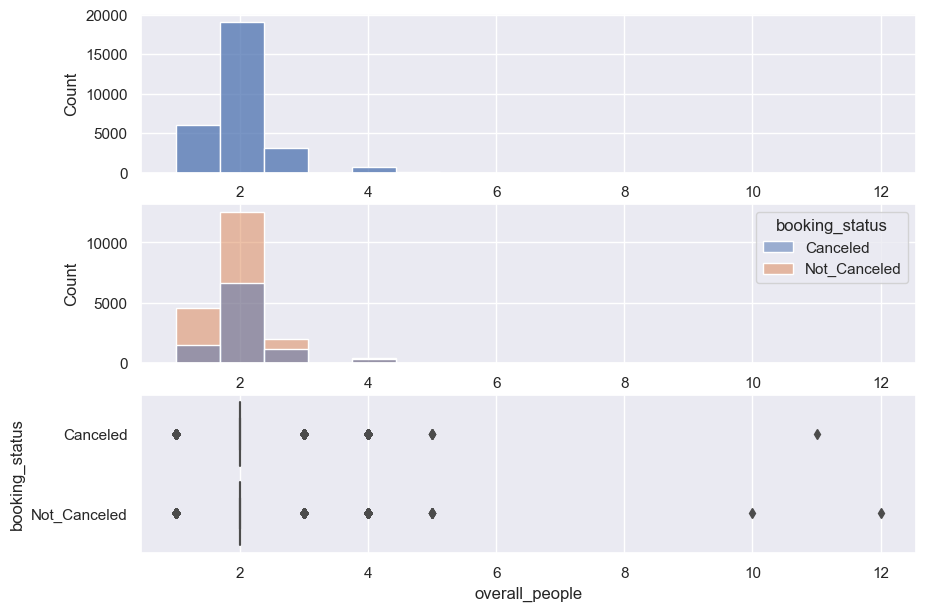

In [499]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="overall_people", ax=ax[0])
t = sns.histplot(data=df_EDA, x="overall_people", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="overall_people", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

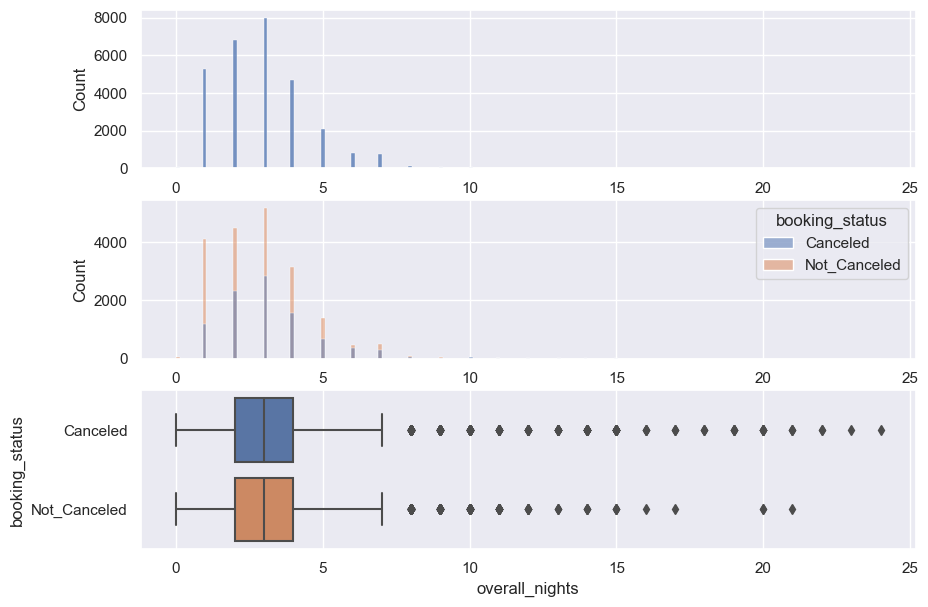

In [500]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="overall_nights", ax=ax[0])
t = sns.histplot(data=df_EDA, x="overall_nights", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="overall_nights", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

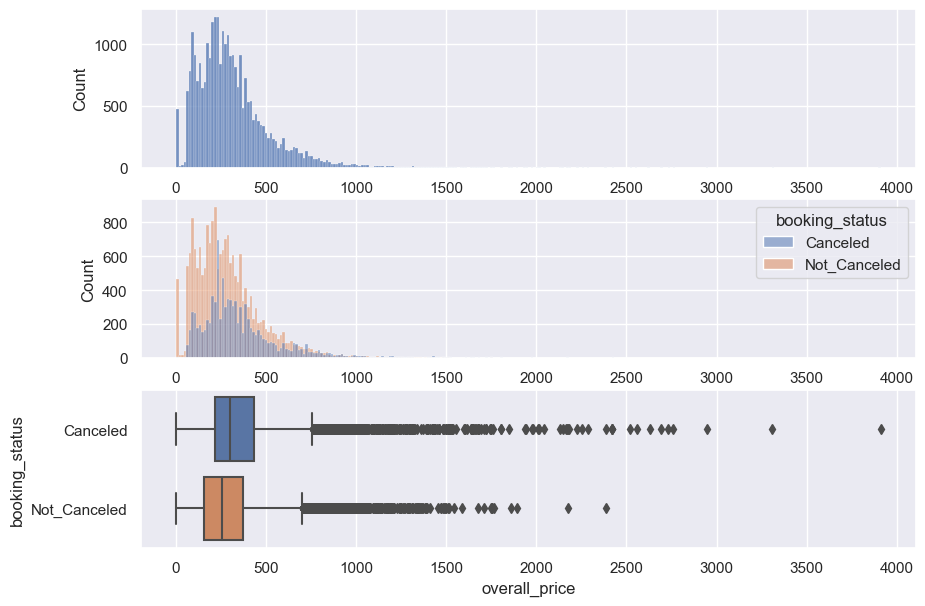

In [501]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x="overall_price", ax=ax[0])
t = sns.histplot(data=df_EDA, x="overall_price", ax=ax[1], hue="booking_status")
t = sns.boxplot(x="overall_price", y="booking_status", orient="h", data=df_EDA, ax=ax[2])

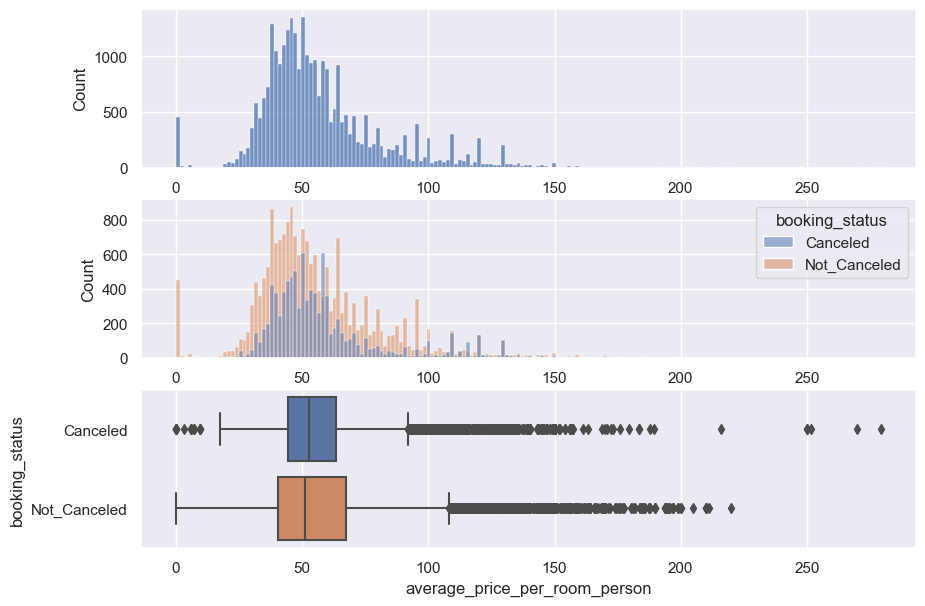

In [502]:
fig, ax = plt.subplots(3, figsize=(10, 7))

t = sns.histplot(data=df_EDA, x='average_price_per_room_person', ax=ax[0])
t = sns.histplot(data=df_EDA, x='average_price_per_room_person', ax=ax[1], hue="booking_status")
t = sns.boxplot(x='average_price_per_room_person', y="booking_status", orient="h", data=df_EDA, ax=ax[2])

All the numerical features seem to be skewed

## 6. Prepare the Data

### 6.1 Handling Skewed Data
Lets analyse some statistical values from these features

In [503]:
df_EDA.agg(
    {
       "avg_price_per_room": ["min", "max", "median","mean", "skew", 'std'],
        "lead_time": ["min", "max", "median", "mean","skew",'std'],
        "overall_people": ["min", "max", "median", "mean","skew",'std'],
        "overall_nights": ["min", "max", "median", "mean","skew",'std'],
        'overall_price': ["min", "max", "median", "mean","skew",'std'],
        'average_price_per_room_person': ["min", "max", "median", "mean","skew",'std']
    }
)

,avg_price_per_room,lead_time,overall_people,overall_nights,overall_price,average_price_per_room_person
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,540.000000,443.000000,12.000000,24.000000,3910.000000,279.200000
median,99.900000,57.000000,2.000000,3.000000,270.000000,51.750000
mean,103.533282,85.127016,1.951482,3.014163,313.152604,57.587991
skew,0.674572,1.302642,0.894121,2.279979,2.577946,1.438188
std,35.147072,85.921809,0.650614,1.794301,219.976723,25.551952


4 of the 6 numerical features have a skew value of over 1 and thus are highly skewed

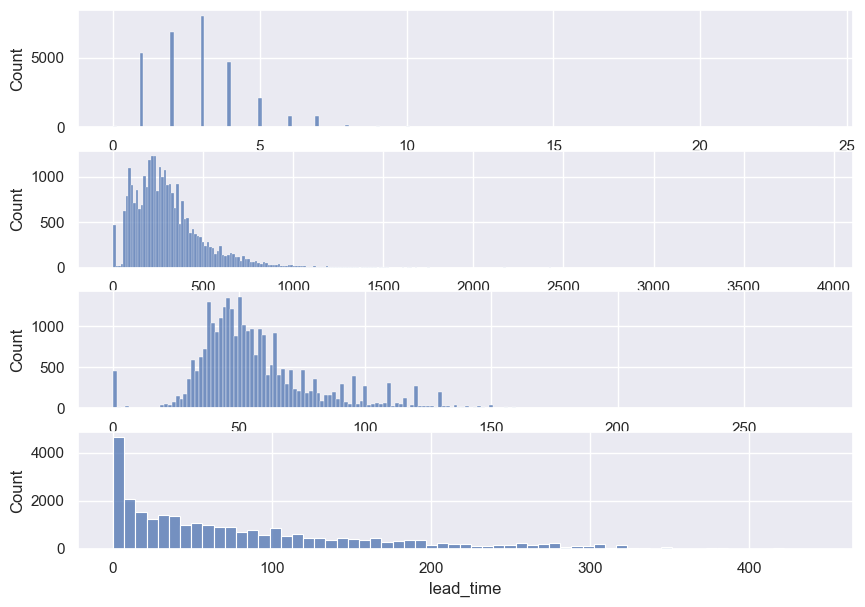

In [504]:
fig, ax = plt.subplots(4, figsize=(10, 7))
t = sns.histplot(df_EDA["overall_nights"], ax=ax[0])
t = sns.histplot(df_EDA["overall_price"], ax=ax[1])
t = sns.histplot(df_EDA["average_price_per_room_person"], ax=ax[2])
t = sns.histplot(df_EDA["lead_time"], ax=ax[3])

reduce_skewness is a function that applies different methods for skewness reduction and selects the best one

c:\Users\janni\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2.28-->0.62
Used method: overall_nights_sqrt


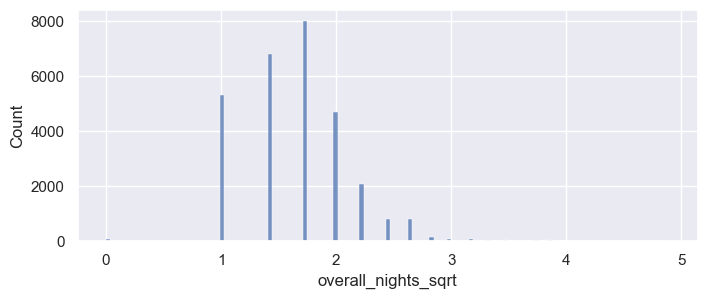

In [505]:
df_EDA["overall_nights"] = reduce_skewness(df_EDA,"overall_nights")

c:\Users\janni\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2.58-->0.48
Used method: overall_price_sqrt


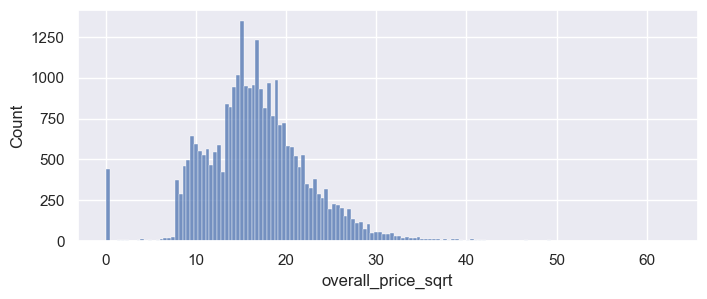

In [506]:
df_EDA["overall_price"] = reduce_skewness(df_EDA,"overall_price")

c:\Users\janni\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.44-->-0.44
Used method: average_price_per_room_person_sqrt


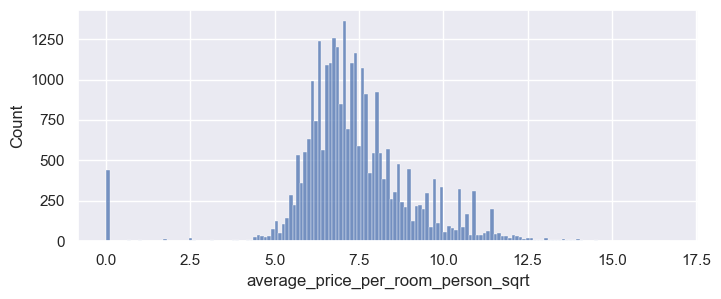

In [507]:

df_EDA["average_price_per_room_person"] = reduce_skewness(df_EDA,"average_price_per_room_person")

c:\Users\janni\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.3-->0.33
Used method: lead_time_sqrt


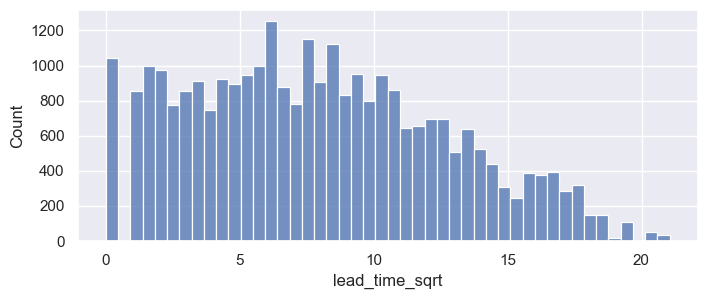

In [508]:
df_EDA["lead_time"] = reduce_skewness(df_EDA,"lead_time")

### 6.2 OneHotEncoding and Scaling

Divide the independent variable from the dependent variables and dropping unnecessary features

In [564]:
y_train = df_EDA["booking_status"]
df_prep = df_EDA.drop(["Booking_ID", "count", "booking_status", "complete_arrival_date"], axis=1)

In [565]:
# Encoding the independent variable
y_train.replace({"Not_Canceled": 1, "Canceled": 0}, inplace=True)

Creation of a pipeline to apply the onehot encoder to the unencoded features and scales the data

In [511]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ("scaler", StandardScaler())
])
pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])


In [512]:
all_features = list(df_prep.columns[0:-1])
unencoded_categorical_features = ["type_of_meal_plan", "market_segment_type", "room_type_reserved"]
encoded_features = [x for x in all_features if x not in unencoded_categorical_features]

In [513]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
        ("cat", cat_pipeline, unencoded_categorical_features),
        ("en", pipeline, encoded_features)
    ])


In [566]:
# Fit and transform the column of categorical data
df_prep = preprocess_pipeline.fit_transform(df_prep)


In [515]:
df_prep.shape


(29020, 33)

## 7. Feature Selection (RFECV)
Select best features automatically using RFECV

In [516]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

rfe = RFECV(estimator=DecisionTreeClassifier())

In [517]:
rfe.fit(df_prep, y_train)


RFECV(estimator=DecisionTreeClassifier())

In [518]:
for i in range(df_prep.shape[1]):
    print("Column: %d, Selected=%s, Rank:%d" % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=True, Rank:1
Column: 1, Selected=True, Rank:1
Column: 2, Selected=False, Rank:4
Column: 3, Selected=True, Rank:1
Column: 4, Selected=True, Rank:1
Column: 5, Selected=False, Rank:2
Column: 6, Selected=True, Rank:1
Column: 7, Selected=True, Rank:1
Column: 8, Selected=True, Rank:1
Column: 9, Selected=True, Rank:1
Column: 10, Selected=True, Rank:1
Column: 11, Selected=False, Rank:3
Column: 12, Selected=True, Rank:1
Column: 13, Selected=True, Rank:1
Column: 14, Selected=True, Rank:1
Column: 15, Selected=True, Rank:1
Column: 16, Selected=True, Rank:1
Column: 17, Selected=True, Rank:1
Column: 18, Selected=True, Rank:1
Column: 19, Selected=True, Rank:1
Column: 20, Selected=True, Rank:1
Column: 21, Selected=True, Rank:1
Column: 22, Selected=True, Rank:1
Column: 23, Selected=True, Rank:1
Column: 24, Selected=True, Rank:1
Column: 25, Selected=True, Rank:1
Column: 26, Selected=False, Rank:5
Column: 27, Selected=True, Rank:1
Column: 28, Selected=True, Rank:1
Column: 29, Selected

In [567]:
# Creation of a dataframe with the selecting data
df_prep = pd.DataFrame(df_prep)
df_prep = df_prep.loc[:,rfe.support_]

## 8. Explore many different models

In [568]:
y_data = y_train.reset_index(drop=True)
#df = pd.concat([df_prep,y_train], axis=1)

In [569]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, valid_index in split.split(df_prep, y_data):
    X_train = df_prep.iloc[train_index]
    X_valid = df_prep.iloc[valid_index]
    y_valid = y_data.iloc[valid_index]
    y_train = y_data.iloc[train_index]


In [522]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,KFold

kfold=StratifiedKFold(n_splits=5,shuffle=True)

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(xgboost.XGBClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

In [523]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv =kfold , n_jobs=-1))
    print(classifier)

SVC(random_state=2)
DecisionTreeClassifier(random_state=2)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2),
                   learning_rate=0.1, random_state=2)
RandomForestClassifier(random_state=2)
ExtraTreesClassifier(random_state=2)
GradientBoostingClassifier(random_state=2)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=No

   CrossValMeans  CrossValerrors           Algorithm
0       0.891734        0.004042                 SVC
1       0.842469        0.007821        DecisionTree
2       0.921074        0.004777            AdaBoost
3       0.945025        0.006451        RandomForest
4       0.938595        0.002461          ExtraTrees
5       0.914095        0.003201    GradientBoosting
6       0.947131        0.002976             Xgboost
7       0.890163        0.004523         KNeighboors
8       0.865279        0.004447  LogisticRegression


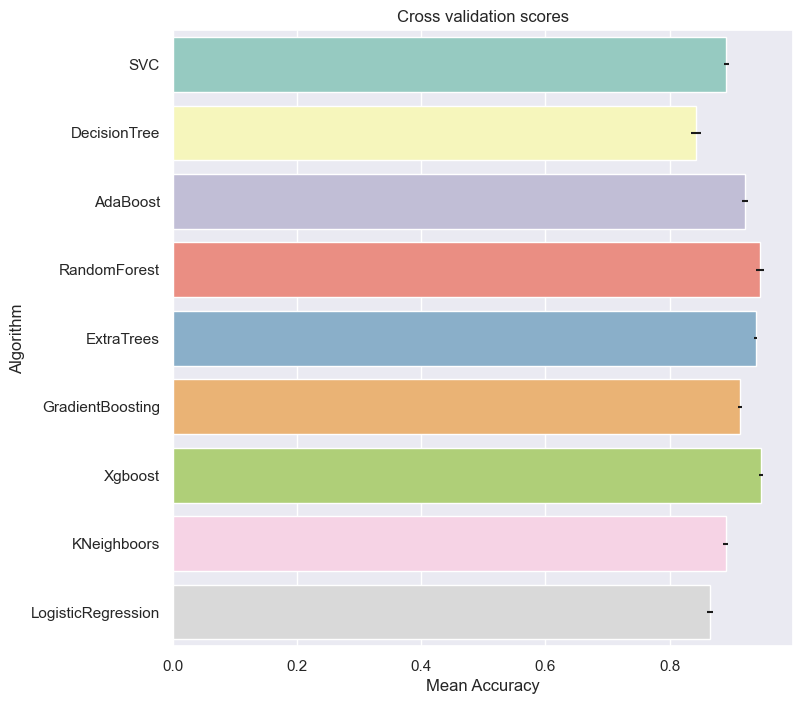

In [524]:
cv_means = []
cv_std   = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","Xgboost","KNeighboors","LogisticRegression"]})
print(cv_res)

g = sns.barplot(x=cv_res["CrossValMeans"],y =cv_res["Algorithm"],  palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

The best 5 models are: AdaBoost, RadomForest, ExtraTrees, GradientBoosting and Xgboost

Lets apply class weightsand see whether the results improve

In [525]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights

array([1.52616356, 0.74362588])

In [526]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state,class_weight=dict(enumerate(class_weights))))
classifiers.append(DecisionTreeClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))))
classifiers.append(ExtraTreesClassifier(random_state=random_state,class_weight=dict(enumerate(class_weights))))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(xgboost.XGBClassifier(random_state=random_state,class_weight=class_weights))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state,class_weight=class_weights))

In [527]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv =kfold , n_jobs=-1))
    print(classifier)

SVC(class_weight={0: 1.5261635550880883, 1: 0.7436258808456118}, random_state=2)
DecisionTreeClassifier(class_weight={0: 1.5261635550880883,
                                     1: 0.7436258808456118},
                       random_state=2)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1.5261635550880883,
                                                                       1: 0.7436258808456118},
                                                         random_state=2),
                   learning_rate=0.1, random_state=2)
RandomForestClassifier(class_weight={0: 1.5261635550880883,
                                     1: 0.7436258808456118},
                       random_state=2)
ExtraTreesClassifier(class_weight={0: 1.5261635550880883,
                                   1: 0.7436258808456118},
                     random_state=2)
GradientBoostingClassifier(random_state=2)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weig

   CrossValMeans  CrossValerrors           Algorithm
0       0.898177        0.003249                 SVC
1       0.842447        0.004613        DecisionTree
2       0.920738        0.006248            AdaBoost
3       0.946427        0.002110        RandomForest
4       0.937814        0.002706          ExtraTrees
5       0.914648        0.004034    GradientBoosting
6       0.948556        0.001491             Xgboost
7       0.891249        0.004940         KNeighboors
8       0.865686        0.003405  LogisticRegression


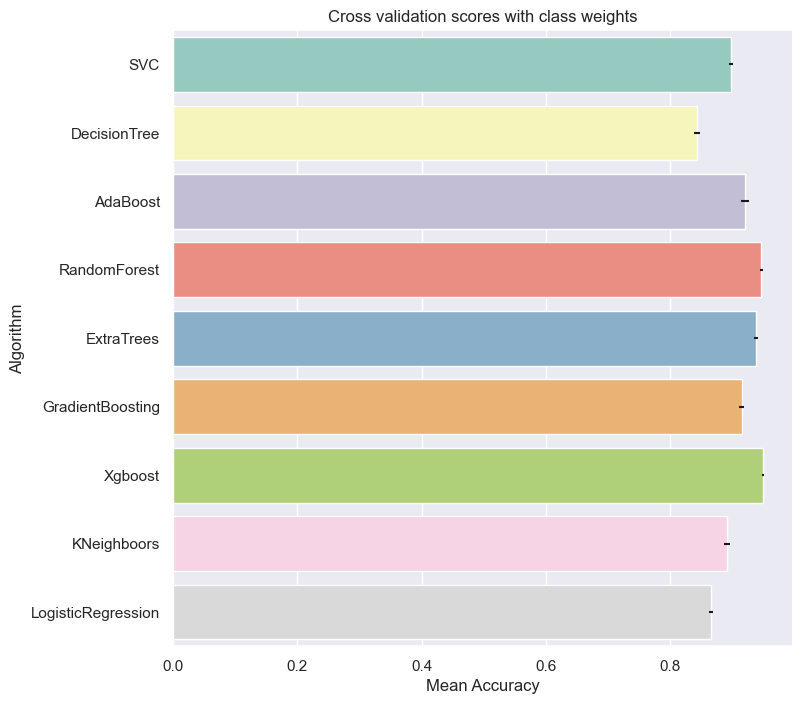

In [528]:
cv_means = []
cv_std   = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","Xgboost","KNeighboors","LogisticRegression"]})
print(cv_res)

g = sns.barplot(x=cv_res["CrossValMeans"],y =cv_res["Algorithm"],  palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores with class weights")

Some of the model performances increased with class weights, some did not.
I will use class weights from now on.

## 9. Fine-tune the best Models

In [529]:
from sklearn.model_selection import RandomizedSearchCV
GBC = GradientBoostingClassifier()
gb_param_grid = {
                 
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [1, 10, 50],
              'min_samples_split': [5, 20, 50]
              
              }
rsGBC=RandomizedSearchCV(estimator=GBC,param_distributions=gb_param_grid,random_state=3,scoring = "roc_auc", 
                                     cv =kfold,n_jobs=1, n_iter=20)
 

rsGBC.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=GradientBoostingClassifier(), n_iter=20, n_jobs=1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01],
                                        'max_depth': [4, 8],
                                        'min_samples_leaf': [1, 10, 50],
                                        'min_samples_split': [5, 20, 50],
                                        'n_estimators': [100, 200, 300]},
                   random_state=3, scoring='roc_auc')

In [530]:
GBC_best = rsGBC.best_estimator_

# Best score
print(rsGBC.best_score_)

0.9521989066334073


In [531]:
GBC_best_y_pred = GBC_best.predict(X_valid)

In [532]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [10,20,50,100],
              
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "bootstrap": [False, True],
              "n_estimators" :[100,300]}


rsRFC = RandomizedSearchCV(RFC,param_distributions = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs= -1, verbose = 1, n_iter=20)

rsRFC.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [10, 20, 50, 100],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300]},
                   scoring='roc_auc', verbose=1)

In [533]:
RFC_best = rsRFC.best_estimator_

# Best score
print(rsRFC.best_score_)

0.9492211018847148


In [534]:
RFC_best_y_pred = RFC_best.predict(X_valid)

In [535]:
XGBoost = xgboost.XGBClassifier()
xgboost_param_grid={
    'learning_rate':[0.01,0.05,0.1,0.2,0.3],
    'n_estimators' :[100,300,500],
    'max_depth'    :[3,5,7,9,10],
    'min_child_weight':[1,3,5,7],
    'colsample_bytree':[0.5,0.7,0.9],
}
rsXGBoost=RandomizedSearchCV(estimator=XGBoost,param_distributions=xgboost_param_grid,random_state=3,scoring = "roc_auc", 
                                     cv =kfold,n_jobs=1, n_iter=20)

rsXGBoost.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           import...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=20, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 5, 7, 9, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 300, 500]},
                   random_state=3, scoring='roc_auc')

In [536]:
XGBoost_best = rsXGBoost.best_estimator_

# Best score
print(rsXGBoost.best_score_)


0.9531899932407562


In [537]:
XG_best_y_pred = XGBoost_best.predict(X_valid)

In [538]:
ETC = ExtraTreesClassifier()

etc_param_grid = {"max_depth": [10,20,50,100],
              
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators" :[100,300,500]}


rsETC = RandomizedSearchCV(ETC,param_distributions = etc_param_grid, cv=kfold, scoring="roc_auc", n_jobs= -1, verbose = 1, n_iter=20)

rsETC.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=ExtraTreesClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [10, 20, 50, 100],
                                        'min_samples_leaf': [1, 3, 10],
                                        'min_samples_split': [2, 3, 10],
                                        'n_estimators': [100, 300, 500]},
                   scoring='roc_auc', verbose=1)

In [539]:
ETC_best = rsETC.best_estimator_

# Best score
print(rsETC.best_score_)

0.9417763576928412


In [540]:
ETC_best_y_pred = ETC_best.predict(X_valid)

In [541]:
ADABoost=AdaBoostClassifier(DecisionTreeClassifier())
adaboost_param_grid={
    'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.3],
    'n_estimators'    :[50,100,250,500],
    'algorithm':["SAMME", "SAMME.R"],

}
rsADABoost=RandomizedSearchCV(estimator=ADABoost,param_distributions=adaboost_param_grid,random_state=3,scoring = "roc_auc", 
                                     cv =kfold,n_jobs=1, n_iter=10)

rsADABoost.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
                   n_jobs=1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'n_estimators': [50, 100, 250, 500]},
                   random_state=3, scoring='roc_auc')

In [542]:
ADABoost_best = rsADABoost.best_estimator_

# Best score
print(rsADABoost.best_score_)


0.9386994146665908


In [543]:
ADA_best_y_pred = ADABoost_best.predict(X_valid)

## 10. Ensemble/Voting Classifier

In [544]:
votingC = VotingClassifier(estimators=[('gbc',GBC_best), ('rfc', RFC_best),
('ADABoost',ADABoost_best),("svc",ETC_best), ('xg', XGBoost)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train,y_train)

In [545]:
votingC_y_pred = votingC.predict(X_valid)

In [563]:
from sklearn.metrics import accuracy_score
print(GBC_best.__class__.__name__, accuracy_score(y_valid, GBC_best_y_pred))
print(RFC_best.__class__.__name__, accuracy_score(y_valid, RFC_best_y_pred))
print(XGBoost_best.__class__.__name__, accuracy_score(y_valid, XG_best_y_pred))
print(ETC_best.__class__.__name__, accuracy_score(y_valid, ETC_best_y_pred))
print(ADABoost_best.__class__.__name__, accuracy_score(y_valid, ADA_best_y_pred))
print(votingC.__class__.__name__, accuracy_score(y_valid, votingC_y_pred))

GradientBoostingClassifier 0.8931771192281185
RandomForestClassifier 0.8930048242591316
XGBClassifier 0.8914541695382495
ExtraTreesClassifier 0.8845623707787733
AdaBoostClassifier 0.8876636802205375
VotingClassifier 0.8962784286698828


## 11. Test and Anayse the Final Model

In [ ]:
df_prep, y_data

In [547]:
X_test = pd.DataFrame(test_data)

In [548]:
X_test['overall_people'] = X_test['no_of_children'] + X_test['no_of_adults']
X_test['overall_nights'] = X_test['no_of_weekend_nights'] + X_test['no_of_week_nights']
X_test['overall_price'] = X_test['avg_price_per_room'] * X_test['overall_nights']
X_test['average_price_per_room_person'] = X_test['avg_price_per_room'] / X_test['overall_people']

In [549]:
X_test["lead_time"] = X_test["lead_time"]**(.5)
X_test["overall_nights"] = X_test["overall_nights"]**(.5)
X_test["overall_price"] = X_test["overall_price"]**(.5)
X_test["average_price_per_room_person"] = X_test["average_price_per_room_person"]**(.5)

In [550]:
y_test = X_test["booking_status"]
X_test = X_test.drop(["Booking_ID", "booking_status"], axis=1)

In [551]:
y_test.replace({"Not_Canceled": 1, "Canceled": 0}, inplace=True)

In [552]:
X_test = preprocess_pipeline.transform(X_test)

In [553]:
X_test= pd.DataFrame(X_test)

In [554]:

X_test = X_test.loc[:,rfe.support_]

VotingClassifier 0.9112336319779463
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2377
           1       0.92      0.95      0.93      4878

    accuracy                           0.91      7255
   macro avg       0.90      0.89      0.90      7255
weighted avg       0.91      0.91      0.91      7255



<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

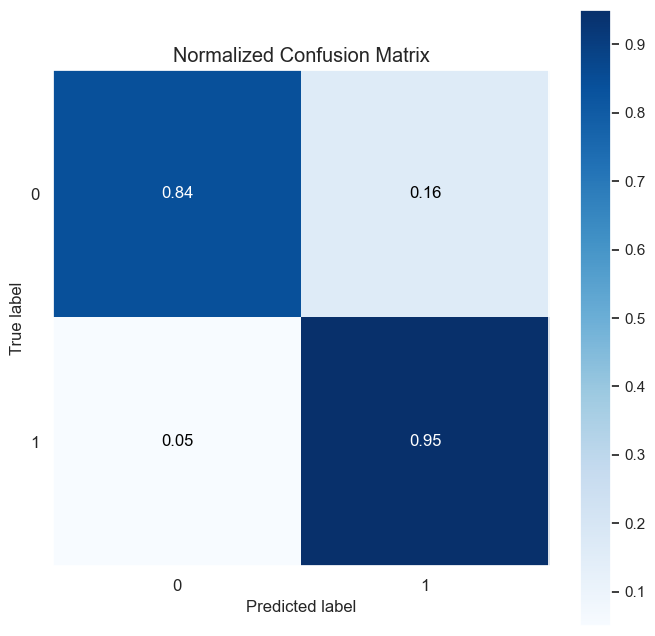

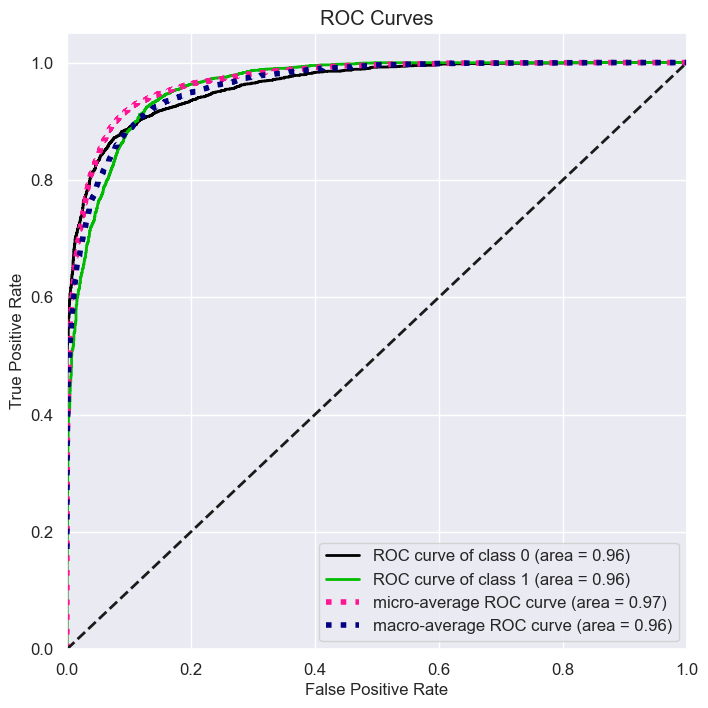

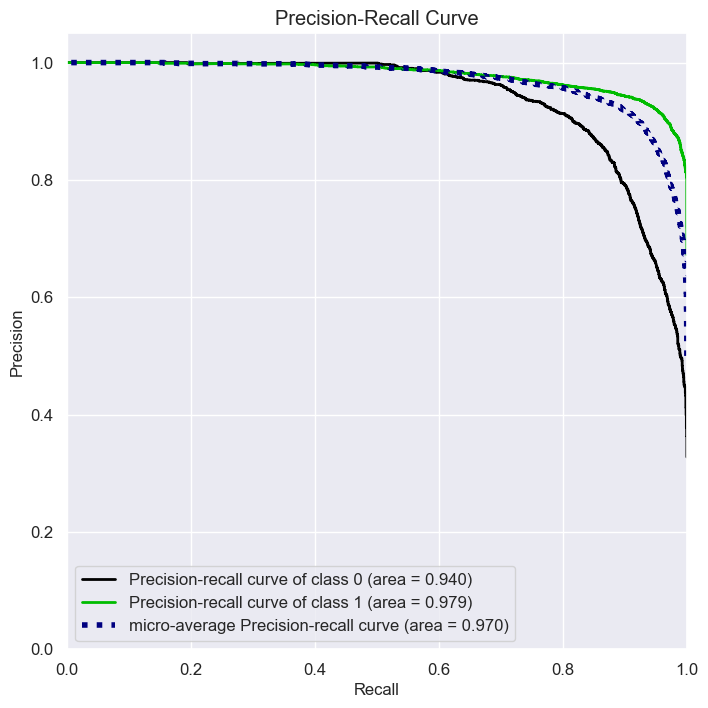

In [435]:
y_test_probas = votingC.predict_proba(X_test)
y_test_predict = votingC.predict(X_test)
from sklearn.metrics import accuracy_score
print(votingC.__class__.__name__, accuracy_score(y_test, y_test_predict))
print(classification_report(y_test, y_test_predict))
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(y_test, y_test_predict, normalize=True)
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_roc(y_test, y_test_probas)
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_precision_recall(y_test, y_test_probas)